In [1]:
# kfold_split_gender_age_height_weight.py
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
from collections import Counter
from pandas.api.types import CategoricalDtype
import shutil
from pathlib import Path

# ============================================================
# 1. Image / Label list
# ============================================================
IMAGE_ROOT = "/data/ephemeral/home/dataset/train/DCM"
LABEL_ROOT = "/data/ephemeral/home/dataset/train/outputs_json"

pngs = sorted([
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _, files in os.walk(IMAGE_ROOT)
    for fname in files
    if fname.lower().endswith(".png")
])

jsons = sorted([
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _, files in os.walk(LABEL_ROOT)
    for fname in files
    if fname.lower().endswith(".json")
])

assert {os.path.splitext(f)[0] for f in pngs} == {os.path.splitext(f)[0] for f in jsons}

# ============================================================
# 2. Load & normalize metadata
# ============================================================
meta_df = pd.read_excel("/data/ephemeral/home/dataset/meta_data.xlsx")

meta_df['gender'] = (
    meta_df['성별']
    .astype(str)
    .str.replace('_x0008_', '', regex=False)
    .str.replace('x0008', '', regex=False)
    .str.strip()
    .map({'여': 'Female', '남': 'Male'})
)

meta_df = meta_df.rename(columns={
    '나이': 'age',
    '키(신장)': 'height',
    '체중(몸무게)': 'weight'
})

print("Overall gender distribution:")
print(meta_df['gender'].value_counts(dropna=False))

# ============================================================
# 3. Binning (ORDER FIXED)
# ============================================================
AGE_ORDER = ['<25', '25-30', '30-40', '40+']
HEIGHT_ORDER = ['<160', '160-168', '168-175', '175+']
WEIGHT_ORDER = ['<55', '55-63', '63-74', '74+']

meta_df['age_bin'] = pd.cut(
    meta_df['age'],
    bins=[0, 25, 30, 40, 200],
    labels=AGE_ORDER,
    right=True
).astype(CategoricalDtype(categories=AGE_ORDER, ordered=True))

meta_df['height_bin'] = pd.cut(
    meta_df['height'],
    bins=[0, 160, 168, 175, 300],
    labels=HEIGHT_ORDER,
    right=True
).astype(CategoricalDtype(categories=HEIGHT_ORDER, ordered=True))

meta_df['weight_bin'] = pd.cut(
    meta_df['weight'],
    bins=[0, 55, 63, 74, 300],
    labels=WEIGHT_ORDER,
    right=True
).astype(CategoricalDtype(categories=WEIGHT_ORDER, ordered=True))

print("\n[Sanity check] bin distribution")
print("Age bin:\n", meta_df['age_bin'].value_counts(sort=False))
print("Height bin:\n", meta_df['height_bin'].value_counts(sort=False))
print("Weight bin:\n", meta_df['weight_bin'].value_counts(sort=False))

# ============================================================
# 4. Stratify label
# ============================================================
meta_df['ID_str'] = meta_df['ID'].apply(lambda x: f"ID{int(x):03d}")

meta_df['stratify_label'] = (
    meta_df['gender'] + "_" +
    meta_df['age_bin'].astype(str) + "_" +
    meta_df['height_bin'].astype(str) + "_" +
    meta_df['weight_bin'].astype(str)
)

id2label = dict(zip(meta_df['ID_str'], meta_df['stratify_label']))

# ============================================================
# 5. Groups / y / X
# ============================================================
groups = [os.path.dirname(f) for f in pngs]
y = np.array([id2label[g] for g in groups])
X = np.ones((len(y), 1))

print("\nOverall stratify label distribution:")
print(dict(Counter(y)))

# ============================================================
# 6. StratifiedGroupKFold
# ============================================================
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups)):
    train_groups = np.array(groups)[train_idx]
    val_groups = np.array(groups)[val_idx]
    overlap = set(train_groups) & set(val_groups)

    print(f"\n===== Fold {fold + 1} =====")
    print("Group overlap:", "None ✅" if len(overlap) == 0 else overlap)
    print(f"Val IDs: {len(set(val_groups))}")


Overall gender distribution:
gender
Female    288
Male      262
Name: count, dtype: int64

[Sanity check] bin distribution
Age bin:
 age_bin
<25      148
25-30    176
30-40    139
40+       87
Name: count, dtype: int64
Height bin:
 height_bin
<160       121
160-168    170
168-175    164
175+        95
Name: count, dtype: int64
Weight bin:
 weight_bin
<55      154
55-63    132
63-74    137
74+      127
Name: count, dtype: int64

Overall stratify label distribution:
{'Female_25-30_160-168_55-63': 14, 'Male_<25_168-175_63-74': 20, 'Female_<25_160-168_<55': 34, 'Female_25-30_<160_<55': 34, 'Female_30-40_<160_<55': 30, 'Female_25-30_160-168_<55': 22, 'Female_30-40_160-168_<55': 30, 'Female_30-40_<160_55-63': 8, 'Female_30-40_168-175_63-74': 4, 'Male_25-30_175+_63-74': 20, 'Female_<25_<160_55-63': 12, 'Female_30-40_168-175_<55': 2, 'Female_40+_160-168_55-63': 24, 'Female_30-40_168-175_55-63': 6, 'Female_30-40_<160_63-74': 8, 'Female_40+_160-168_74+': 4, 'Male_30-40_168-175_63-74': 18, 'Male_

/data/ephemeral/home/py310/lib/python3.10/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


/data/ephemeral/home/py310/lib/python3.10/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


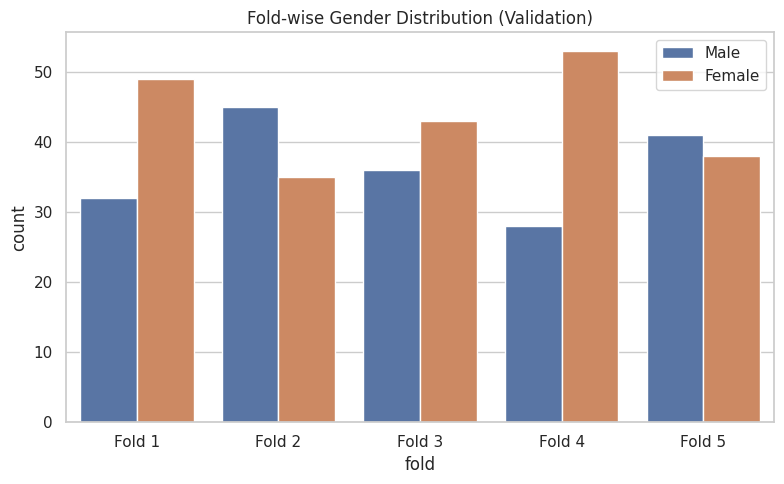

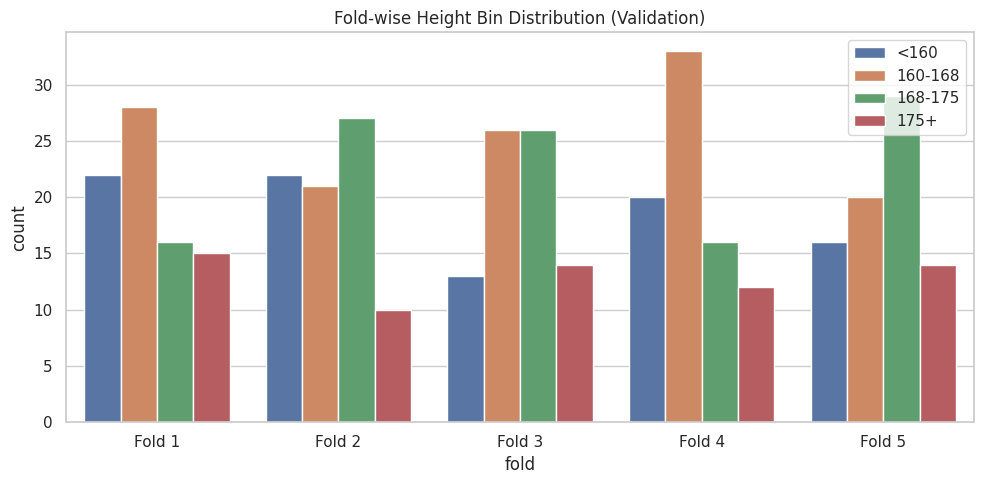

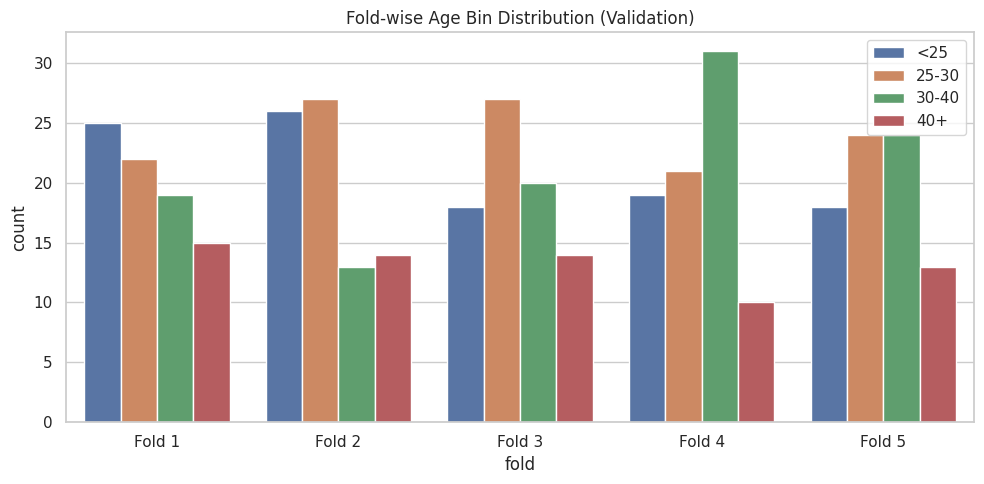

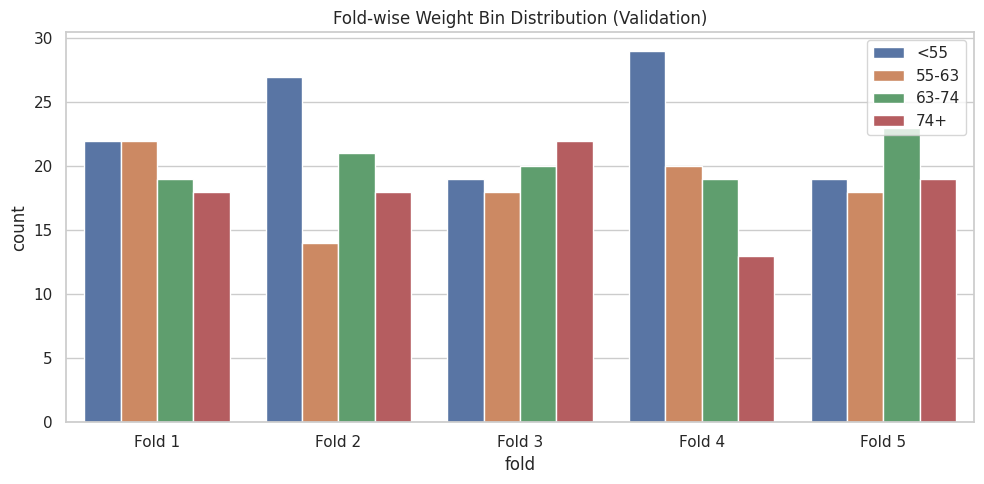

In [2]:
# ============================================================
# 7. Fold-wise Distribution Visualization
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

id2meta = meta_df.set_index('ID_str')

fold_val_ids = {
    fold + 1: list(set(np.array(groups)[val_idx]))
    for fold, (_, val_idx) in enumerate(cv.split(X, y, groups))
}

# -----------------------------
# Gender
# -----------------------------
gender_dist = []
for fold, ids in fold_val_ids.items():
    for g, cnt in id2meta.loc[ids]['gender'].value_counts(sort=False).items():
        gender_dist.append({"fold": f"Fold {fold}", "gender": g, "count": cnt})

df = pd.DataFrame(gender_dist)
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="fold", y="count", hue="gender")
plt.title("Fold-wise Gender Distribution (Validation)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# -----------------------------
# Height bin
# -----------------------------
height_dist = []
for fold, ids in fold_val_ids.items():
    for b, cnt in id2meta.loc[ids]['height_bin'].value_counts(sort=False).items():
        height_dist.append({"fold": f"Fold {fold}", "height_bin": b, "count": cnt})

df = pd.DataFrame(height_dist)
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df, x="fold", y="count",
    hue="height_bin", hue_order=HEIGHT_ORDER
)
plt.title("Fold-wise Height Bin Distribution (Validation)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# -----------------------------
# Age bin
# -----------------------------
age_dist = []
for fold, ids in fold_val_ids.items():
    for b, cnt in id2meta.loc[ids]['age_bin'].value_counts(sort=False).items():
        age_dist.append({"fold": f"Fold {fold}", "age_bin": b, "count": cnt})

df = pd.DataFrame(age_dist)
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df, x="fold", y="count",
    hue="age_bin", hue_order=AGE_ORDER
)
plt.title("Fold-wise Age Bin Distribution (Validation)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# -----------------------------
# Weight bin
# -----------------------------
weight_dist = []
for fold, ids in fold_val_ids.items():
    for b, cnt in id2meta.loc[ids]['weight_bin'].value_counts(sort=False).items():
        weight_dist.append({"fold": f"Fold {fold}", "weight_bin": b, "count": cnt})

df = pd.DataFrame(weight_dist)
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df, x="fold", y="count",
    hue="weight_bin", hue_order=WEIGHT_ORDER
)
plt.title("Fold-wise Weight Bin Distribution (Validation)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [ ]:
###################

fold_id_split = {}

for fold, (_, val_idx) in enumerate(cv.split(X, y, groups)):
    val_ids = set(np.array(groups)[val_idx])
    train_ids = set(groups) - val_ids

    fold_id_split[fold] = {
        "train_ids": sorted(train_ids),
        "val_ids": sorted(val_ids)
    }

    print(f"Fold {fold}: train={len(train_ids)}, val={len(val_ids)}")

def copy_id_folders(id_list, src_root, dst_root):
    os.makedirs(dst_root, exist_ok=True)

    for id_ in id_list:
        src_dir = os.path.join(src_root, id_)
        dst_dir = os.path.join(dst_root, id_)

        if not os.path.exists(src_dir):
            print(f"⚠️ Missing source: {src_dir}")
            continue

        if os.path.exists(dst_dir):
            # 이미 있으면 skip (중복 방지)
            continue

        shutil.copytree(src_dir, dst_dir)

BASE_OUT_DIR = "/data/ephemeral/home/dataset"

for fold, split in fold_id_split.items():
    print(f"\n=== Creating fold {fold} dataset ===")

    fold_dir = os.path.join(BASE_OUT_DIR, f"fold{fold}")

    # train / val 디렉토리
    train_dcm = os.path.join(fold_dir, "train/DCM")
    train_json = os.path.join(fold_dir, "train/outputs_json")
    val_dcm = os.path.join(fold_dir, "val/DCM")
    val_json = os.path.join(fold_dir, "val/outputs_json")

    # copy train
    copy_id_folders(split["train_ids"], IMAGE_ROOT, train_dcm)
    copy_id_folders(split["train_ids"], LABEL_ROOT, train_json)

    # copy val
    copy_id_folders(split["val_ids"], IMAGE_ROOT, val_dcm)
    copy_id_folders(split["val_ids"], LABEL_ROOT, val_json)

    print(f"✅ Fold {fold} done")

ROOT = "/data/ephemeral/home/dataset"

for fold in range(5):
    train_dir = os.path.join(ROOT, f"fold{fold}", "train", "DCM")
    val_dir   = os.path.join(ROOT, f"fold{fold}", "val", "DCM")

    train_ids = set(os.listdir(train_dir))
    val_ids   = set(os.listdir(val_dir))

    overlap = train_ids & val_ids

    assert len(overlap) == 0, f"❌ Fold {fold} overlap detected: {overlap}"

    print(f"✅ Fold {fold}: train/val ID separation OK "
          f"(train={len(train_ids)}, val={len(val_ids)})")
